# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
device = torch.device('cpu')



In [3]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]

        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)

            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)

            image_array.append(array)

        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]

    def __repr__(self):
        return str(self.dataframe.head())


In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64)
print(dataset)

#upload model
model_path = path_to_project_root + 'models/brain_tumor_cnn.pt'
try:
    model = torch.load(model_path)
    model.eval()
except Exception:
    print('proceed with training')

                                         image  labels
0   ../../../data/brain_tumor_imgs/no\No16.jpg       0
1   ../../../data/brain_tumor_imgs/yes\Y98.JPG       1
2   ../../../data/brain_tumor_imgs/yes\Y31.jpg       1
3  ../../../data/brain_tumor_imgs/yes\Y182.JPG       1
4  ../../../data/brain_tumor_imgs/yes\Y242.JPG       1
proceed with training


#### MODEL with SyMPC wraper

In [6]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [43]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200
plot = False

def train(model, dataset, num_epochs = 100, batch_size = 32):
    model.train()

    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        for i in range(len(dataset)//batch_size):
            optimizer.zero_grad()
            image, label = dataset[i*batch_size:(i+1)*batch_size]
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
        if epoch%10 == 0:
            print(f'Epochs: {epoch} Loss: {total_loss/i}')
        loss_list.append(total_loss/batch_size)
    return loss_list
loss_list = train(model, dataset, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

Epochs: 0 Loss: 179.74134826660156
Epochs: 10 Loss: 0.777853786945343
Epochs: 20 Loss: 0.46413707733154297
Epochs: 30 Loss: 0.38910529017448425
Epochs: 40 Loss: 0.6113932132720947
Epochs: 50 Loss: 0.37203726172447205
Epochs: 60 Loss: 0.24659772217273712
Epochs: 70 Loss: 0.17113466560840607
Epochs: 80 Loss: 0.1554591953754425
Epochs: 90 Loss: 0.1691761612892151
Epochs: 100 Loss: 0.44452130794525146
Epochs: 110 Loss: 0.327058345079422
Epochs: 120 Loss: 0.30482789874076843
Epochs: 130 Loss: 0.23191718757152557
Epochs: 140 Loss: 0.21013016998767853
Epochs: 150 Loss: 0.2813282907009125
Epochs: 160 Loss: 0.4373877942562103
Epochs: 170 Loss: 0.37124648690223694
Epochs: 180 Loss: 0.3610846698284149
Epochs: 190 Loss: 0.3597133457660675


In [45]:
#Evaluate model

def test(num_of_predictions):
    model.eval()
    correctly_predicted = 0
    with torch.no_grad():
        for idx, (image, label) in enumerate(dataset):
            pred = model.forward(image.float())
            pred = torch.argmax(pred, dim=1)
            # print(f"PRED: {pred} - LABEL:{label}")
            correctly_predicted += (pred == label)
            # print(correctly_predicted)
            if idx == num_of_predictions: break
    accuracy = correctly_predicted.sum() / float(num_of_predictions)
    print(f'Test Accuracy of the model on the test images: {accuracy:.2f}')
test(250)

Test Accuracy of the model on the test images: 0.82


tensor([[-0.1929,  0.1988]], grad_fn=<AddmmBackward>)
tensor([[-42.9867,  43.0358]], grad_fn=<AddmmBackward>)
tensor([[-12.3593,  12.4358]], grad_fn=<AddmmBackward>)
tensor([[-0.1929,  0.1988]], grad_fn=<AddmmBackward>)
tensor([[-4.3762,  4.3990]], grad_fn=<AddmmBackward>)
tensor([[ 3.4967, -3.4608]], grad_fn=<AddmmBackward>)
tensor([[-0.1929,  0.1988]], grad_fn=<AddmmBackward>)
tensor([[ 1.6153, -1.5294]], grad_fn=<AddmmBackward>)
tensor([[ 3.6229, -3.6499]], grad_fn=<AddmmBackward>)
tensor([[-4.8816,  4.8470]], grad_fn=<AddmmBackward>)
tensor([[ 3.6229, -3.6499]], grad_fn=<AddmmBackward>)
tensor([[-2.9732,  3.0364]], grad_fn=<AddmmBackward>)
tensor([[-8.1850,  8.3315]], grad_fn=<AddmmBackward>)
tensor([[-9.6616,  9.8559]], grad_fn=<AddmmBackward>)
tensor([[-0.1488,  0.1564]], grad_fn=<AddmmBackward>)
tensor([[-0.1929,  0.1988]], grad_fn=<AddmmBackward>)
tensor([[ 4.1707, -4.0320]], grad_fn=<AddmmBackward>)
tensor([[-0.1929,  0.1988]], grad_fn=<AddmmBackward>)
tensor([[-3.8825,  4.017

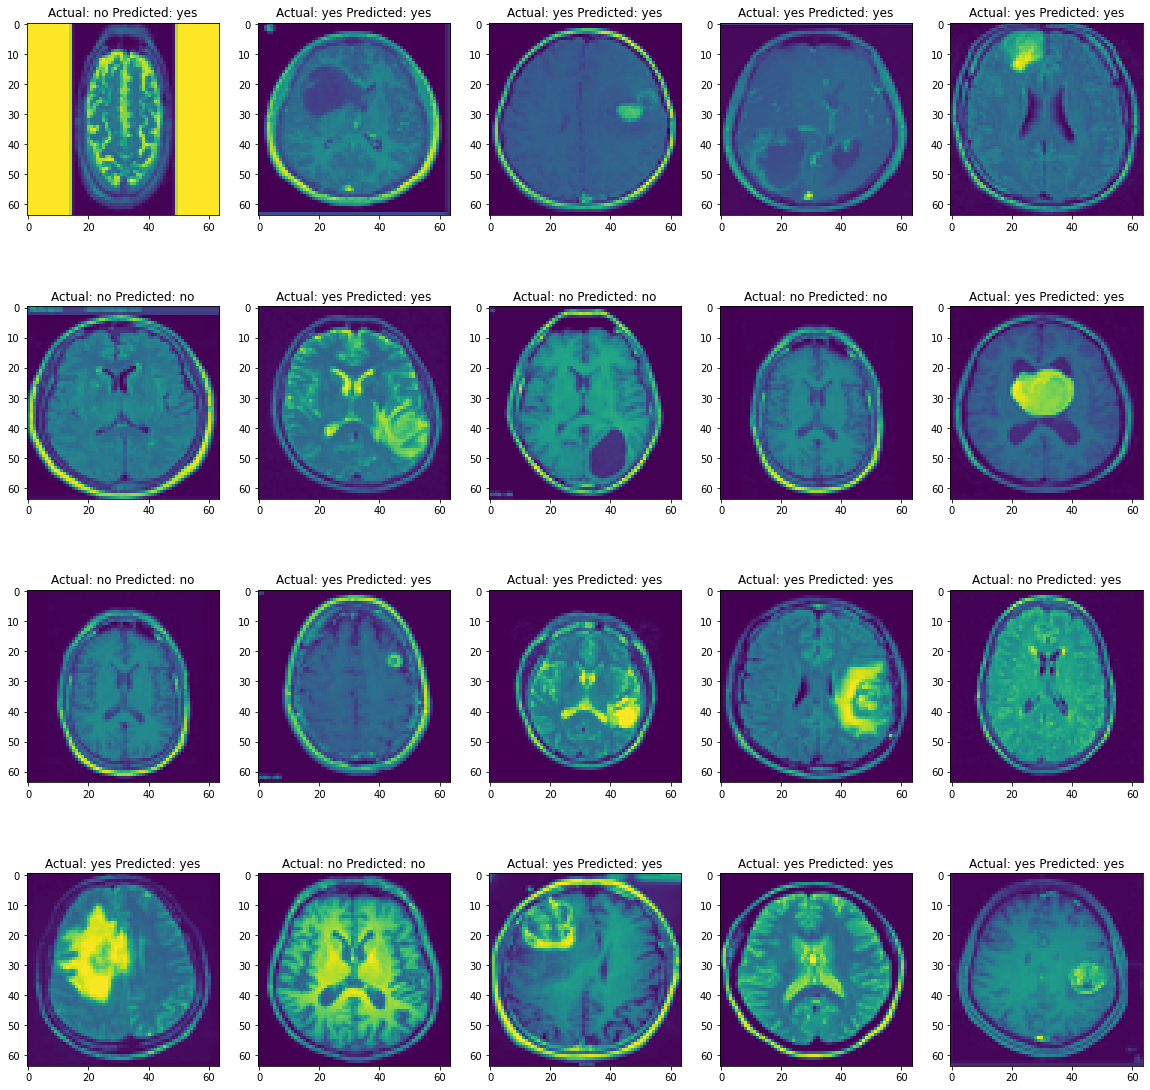

In [56]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model(data.float())
    print(pred)
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()

#### ORIGINAL MODEL

In [ ]:
class BrainTumorModelOriginal(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,128,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(30,64)
        self.linear2 = nn.Linear(64,32)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(30720,2)
        # self.linear3 = nn.Linear(63488,2)

    def forward(self,x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.linear1(x))
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.linear3(x)

        return x

In [ ]:
model_orig = BrainTumorModelOriginal()
print(model_orig)

In [58]:

model_orig = BrainTumorModelOriginal()
epochs = 100
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):

        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model_orig.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')
        break
# in case decrease size in half

torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
Epochs: 0 Loss: 1.739948153

In [50]:
#todo make accuracy


In [11]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [12]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    data_pointers = []

    split_size = int(len(data)/len(session.parties))+1
    for index in range(0,len(session.parties)):
        ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        data_pointers.append(ptr)

    return data_pointers

In [13]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [72]:
ptrs = []
labels = []
for i, (img, lbl) in enumerate(dataset):
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)
    if i == 10: break
ptrs

[[MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,


In [25]:
dataset[0][0][0][0][0]

tensor([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        224,  12,   0,   2,   2,   1,   1,   1,   1,   3,   2,   0,   2,   9,
         17,  17,  18,  15,  24,  16,  14,  20,  25,  20,   6,   1,   2,   2,
          1,   1,   2,   2,   2,   0,  12, 225, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255], dtype=torch.uint8)

In [47]:
mpc_model = model.share(session)
mpc_model

In [73]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

C:\Users\ollyt\anaconda3\envs\pysyft\lib\site-packages\sympc\protocol\fss\fss.py:140: UserWarning: Temporarily disabling CUDA as FSS does not support it
  warnings.warn("Temporarily disabling CUDA as FSS does not support it")
[2021-11-03T19:48:54.592274+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dbac1c480734b28ab3f56a4c094546f>.
[2021-11-03T19:48:54.595238+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b682774e86d4ae7bdc0943df5e4809e>.
[2021-11-03T19:48:54.711415+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9424ed1ba4514c609dfe4e27169a4bfb>.
[2021-11-03T19:48:54.714415+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fca49e98c6824fdfa2fe23bf8311e27d>.
[2021-11-03T19:49:56.420966+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memo

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2656.1304,  4074.5186]])


[2021-11-03T19:50:31.536472+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 553144bd4e764695809624a22ce1fbff>.
[2021-11-03T19:50:34.627890+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 092311e2dbd34d2e8e7f24cb24dd3216>.
[2021-11-03T19:50:34.629854+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74e83bf72f234921939e858e3831e20b>.
[2021-11-03T19:51:32.245278+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0e0605efe9d48ce9f4ee1a1519874f9>.
[2021-11-03T19:51:32.247277+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 031aacc7fe6949799e8487953cc52f1d>.
[2021-11-03T19:52:00.884020+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a8f826d51e0447

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3609.0732,  3634.6675]])


[2021-11-03T19:52:07.612416+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e5220f494de48ae84cabe6ac0abc859>.
[2021-11-03T19:52:07.619417+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 671b0cf9e70d482480d911d8fcbc9af7>.
[2021-11-03T19:52:07.629416+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1e68ad851a94df7adfd1ad03b43fe01>.
[2021-11-03T19:52:07.637417+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b600bb7f5f574ff198694aeefa8e8d00>.
[2021-11-03T19:52:07.670416+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 416e0a19b946420bae8f5fb64bff1dcb>.
[2021-11-03T19:52:07.673418+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6816b4f0b6c4ee

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-468.3895,  506.8749]])


[2021-11-03T19:53:46.502618+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d38b33a2ae4946a5989c251ed3b59a5e>.
[2021-11-03T19:53:46.504591+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3293286add44c98a6fe5cec5384561b>.
[2021-11-03T19:53:46.510624+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9608dc902a1343b9a75cb2b53f531528>.
[2021-11-03T19:53:46.512589+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1656495bf659439bb436b87625dbf46d>.
[2021-11-03T19:53:46.519619+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1231b4c0eb546c482819975e47da438>.
[2021-11-03T19:53:46.521619+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc6a8ed14bcd4fb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 928.6992, -969.7780]])


[2021-11-03T19:55:23.765622+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01140d7d4aad480c81651adcacc762aa>.
[2021-11-03T19:55:23.767586+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1df4207b79214ab2a98f5e63cd401e71>.
[2021-11-03T19:55:23.772616+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6bdb7df3042d4c62888903a68ed80fbd>.
[2021-11-03T19:55:23.774598+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41d3a6261c934e74932afcde4860fd41>.
[2021-11-03T19:55:23.781622+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eedb0819ecfb4686959288cf1f32750e>.
[2021-11-03T19:55:23.783589+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df782f33aea04dd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1028.0156,  1106.5126]])


[2021-11-03T19:56:59.345365+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e18a8f168496453f970b67f9b3e0711b>.
[2021-11-03T19:56:59.348338+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6bdbc5f131944d88e9963509c0b2e6b>.
[2021-11-03T19:56:59.352336+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4d7efd5af664971ac190d77597823a5>.
[2021-11-03T19:56:59.354338+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 828c3857751a452ca0329ec74631857b>.
[2021-11-03T19:56:59.510336+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f6f520ee7704a7f8f36e41c2cbe6f07>.
[2021-11-03T19:56:59.513337+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73a144aca5cb4a6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1671.7400,  1665.4603]])


[2021-11-03T19:58:35.694152+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f1cdee62ba8c4e3381097fa3c36a84e6>.
[2021-11-03T19:58:35.697187+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b84debf0ccc6478db3a2fdaf27dae833>.
[2021-11-03T19:58:35.700187+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1e5876c8a1a4c73a7b14a355d025f40>.
[2021-11-03T19:58:35.703187+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4875a7a233ca492db828b2763174b116>.
[2021-11-03T19:59:33.948848+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 322cfe8db4f6427cac3aa85788d9ef63>.
[2021-11-03T19:59:33.950849+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 781d19da8206443

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2842.2261,  2886.0029]])


[2021-11-03T20:00:12.398972+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 664fb664e6814dcab11a170ae00d87b5>.
[2021-11-03T20:00:12.401972+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 737b2940a1994a81ac327d103073658f>.
[2021-11-03T20:00:12.405969+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62d7d16af70b4c709032366237333530>.
[2021-11-03T20:00:12.408971+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce0359958cdc42cfa536becb7f53c614>.
[2021-11-03T20:00:12.415971+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a60b0cd128e4e71a064df6069eee2d9>.
[2021-11-03T20:00:12.417984+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9515386b7d95492

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.2156, 13.9338]])


[2021-11-03T20:01:48.829435+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 55066cac66354886ad3b9a55b7b31155>.
[2021-11-03T20:01:48.832412+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9ca6020b1144037bbafa10a0cd6e41d>.
[2021-11-03T20:01:48.837433+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8983e98fce44268acd5ca0268ca31ea>.
[2021-11-03T20:01:48.840432+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39cea069e9c749c59076223e633f395f>.
[2021-11-03T20:01:48.846426+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31d827de2db942478591d0cad848e66a>.
[2021-11-03T20:01:48.849428+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e89ff47bc774e8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-347.4788,  413.5557]])


[2021-11-03T20:03:28.184514+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d0e6fb5ea749470e99a8dae2e9066506>.
[2021-11-03T20:03:28.194593+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 874bf7d828284af69d09bce462bd98e8>.
[2021-11-03T20:03:28.198761+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8dd0b1c1a6de400ba8428749bb073a20>.
[2021-11-03T20:03:28.201276+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c84e94bd3b34443ad0a0167b36b1599>.
[2021-11-03T20:03:28.321159+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 077f700ddd8f402ab1dc8948a8c10ed9>.
[2021-11-03T20:03:28.337069+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d06f434a32bc4ee

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-629.5863,  551.5257]])


[2021-11-03T20:05:14.061022+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9565c068adb402ab2c17f980f35f749>.
[2021-11-03T20:05:14.064022+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e79f22047f974ce197011f7460d04efc>.
[2021-11-03T20:05:14.235239+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99b0571c75d14c1f94188b9e575ea646>.
[2021-11-03T20:05:14.237239+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ece1043744084d97b11502b5e6dad223>.
[2021-11-03T20:06:18.405581+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d57169c794494087b8b4c27c36ae3cc3>.
[2021-11-03T20:06:18.408585+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77f795503ddd4e0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-337.2173,  337.8356]])


[tensor([[-2656.1304,  4074.5186]]),
 tensor([[-3609.0732,  3634.6675]]),
 tensor([[-468.3895,  506.8749]]),
 tensor([[ 928.6992, -969.7780]]),
 tensor([[-1028.0156,  1106.5126]]),
 tensor([[-1671.7400,  1665.4603]]),
 tensor([[-2842.2261,  2886.0029]]),
 tensor([[ 3.2156, 13.9338]]),
 tensor([[-347.4788,  413.5557]]),
 tensor([[-629.5863,  551.5257]]),
 tensor([[-337.2173,  337.8356]])]

[2021-11-03T20:15:06.866971+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cac21ca9807464daa176b316b12e0ce>.
[2021-11-03T20:15:06.870880+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2642add63963433e8af9a8765a6c79aa>.
[2021-11-03T20:15:06.875878+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81deca06f9b6467585dd6abee94abdbd>.
[2021-11-03T20:15:06.878894+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1c914e884eb456eac238e139156377c>.
[2021-11-03T20:15:06.887135+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9502a5ec3df740049378bd36b4a7a292>.
[2021-11-03T20:15:06.889876+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc35c13535bc439

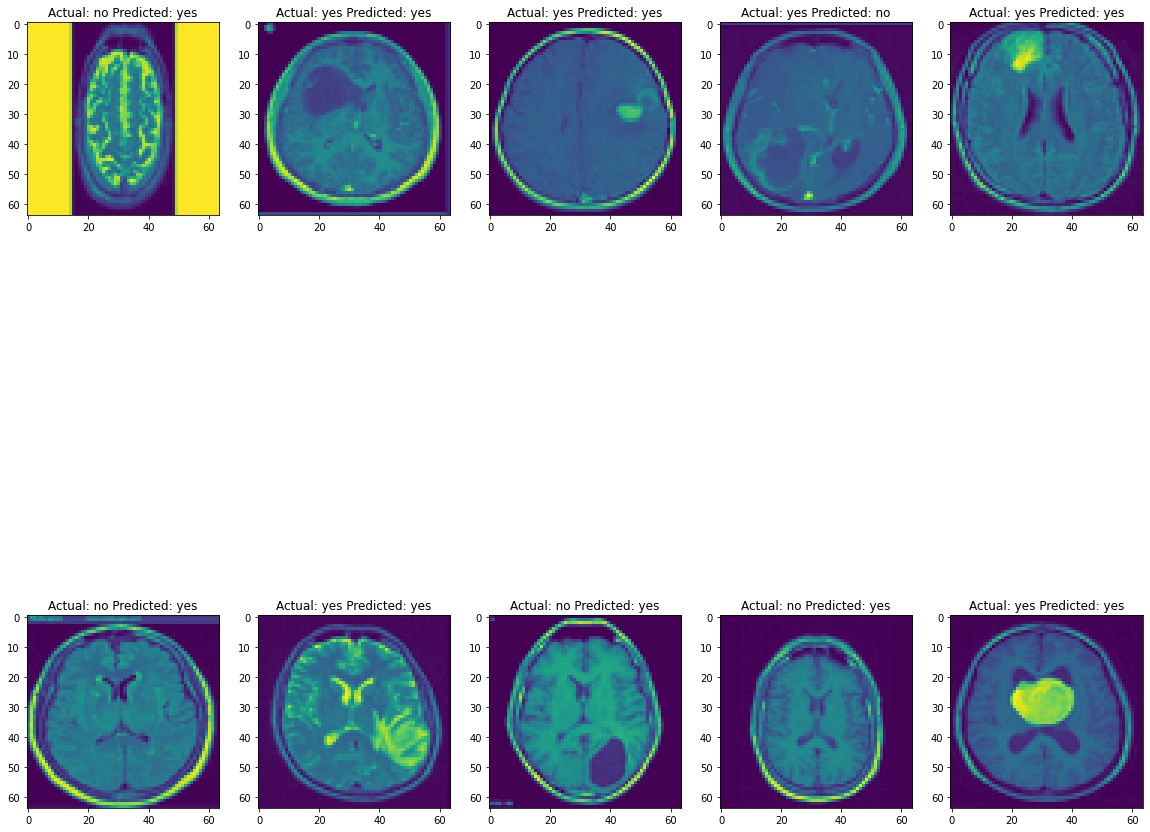

Time for inference: 1086.4509773254395


In [74]:
fig = plt.figure(figsize=(20,20))
for i in range(10):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(2,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")

TypeError: share() missing 1 required positional argument: 'session'